# Install Dataset

In [23]:
!gdown "1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96" -O "tumor_dataset.rar"

Downloading...
From: https://drive.google.com/uc?id=1_PhKR-1DdeOl5K5E9IV5G-tckNNq-X96
To: /content/tumor_dataset.rar
100% 317M/317M [00:01<00:00, 178MB/s]


In [24]:
!pip install unrar -q

In [25]:
!rm -rf "/content/tumor_dataset"
!unrar x "tumor_dataset.rar" &> /dev/null

In [26]:
!ls -l "/content/tumor_dataset/Glioma/" | wc -l
!ls -l "/content/tumor_dataset/Meningioma" | wc -l
!ls -l "/content/tumor_dataset/Pituitary/" | wc -l

1427
709
931


# Imports

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

# Enable GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('[device]', device)


[device] cuda


# Setup Dataset

In [28]:
# dataset path and image size
# dataset_path = "/content/drive/MyDrive/brain_tumor_dataset/"
dataset_path = "/content/tumor_dataset"
image_size = (224, 224)
# Load and preprocess the dataset
classes = ["Glioma", "Meningioma", "Pituitary"]

images_path = []
labels = []
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        images_path.append(image_path)
        labels.append(i)

# Convert the lists to numpy arrays
images_path = np.array(images_path)
labels = np.array(labels)

print('[images_path]', len(images_path), images_path[0], images_path[-1])
print('[labels]', len(labels), labels[:10], labels[-10:])

# Create the train-test split
train_images_path, test_images_path, train_labels, test_labels = train_test_split(images_path, labels, test_size=0.2, stratify=labels, random_state=42)

print('[train_images_path]', len(train_images_path), train_images_path[0], train_images_path[-1])
print('[train_labels]', len(train_labels), train_labels[:10], train_labels[-10:])
print('[test_images_path]', len(test_images_path), test_images_path[0], test_images_path[-1])
print('[test_labels]', len(test_labels), test_labels[:10], test_labels[-10:])


[images_path] 3064 /content/tumor_dataset/Glioma/2.0---MR024780G-i2279.bmp /content/tumor_dataset/Pituitary/3.0---97461-i1400.bmp
[labels] 3064 [0 0 0 0 0 0 0 0 0 0] [2 2 2 2 2 2 2 2 2 2]
[train_images_path] 2451 /content/tumor_dataset/Glioma/2.0---MR024780G-i2885.bmp /content/tumor_dataset/Glioma/2.0---MR051796-i2574.bmp
[train_labels] 2451 [0 0 0 0 0 1 2 0 0 0] [0 2 2 2 0 1 1 2 2 0]
[test_images_path] 613 /content/tumor_dataset/Glioma/2.0---MR051586-i2929.bmp /content/tumor_dataset/Pituitary/3.0---103671-i1325.bmp
[test_labels] 613 [0 0 1 1 1 0 1 0 2 2] [1 1 0 0 2 1 0 0 2 2]


In [29]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_path, labels):
        self.images_path = images_path
        self.labels = labels

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        # get image path
        image_path = self.images_path[idx]
        # get image label
        label = self.labels[idx]
        # read actual image
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image, image_size)
        # convert to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # convert to pytorch tensor
        image = torch.from_numpy(image)
        # normalize for better performance
        image = image / 255
        # reorder according to pytorch requirements
        image = image.permute((2, 0, 1))
        return image, label


# Define Common Functions

In [30]:
def training_loop(train_loader, val_loader, model, optimizer, criterion, epochs, fold, device):
    # Lists to store metrics for this fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_predictions = []
    val_probs = []

    # Training loop for this fold
    for epoch in range(epochs):
        #################
        # TRAINING PART #
        #################
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_train_samples = len(train_loader.dataset)

        for idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * len(labels)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += sum(predicted == labels)

        average_accuracy = correct_predictions / total_train_samples
        average_loss = running_loss / total_train_samples
        print(f"[train][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_loss}, Accuracy: {average_accuracy}")
        train_accuracies.append(average_accuracy.item())
        train_losses.append(average_loss)

        ###################
        # VALIDATION PART #
        ###################
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0

        total_val_samples = len(val_loader.dataset)

        with torch.no_grad():
            for idx, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val_predictions += sum(predicted == labels)


        average_val_accuracy = correct_val_predictions / total_val_samples
        average_val_loss = val_loss / total_val_samples
        print(f"[valid][Fold {fold + 1}][Epoch {epoch + 1}]: Loss {average_val_loss}, Accuracy: {average_val_accuracy}")
        val_accuracies.append(average_val_accuracy.item())
        val_losses.append(average_val_loss)



    model.train()

    return train_accuracies, train_losses, val_accuracies, val_losses


In [31]:
def plot_macro_roc_curve(fprs, tprs, aucs):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(fprs)):
        plt.plot(fprs[i], tprs[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-averaged ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_macro_precision_recall_curve(precisions, recalls):
    plt.figure()
    colors = ['red', 'green', 'blue']
    for i in range(len(precisions)):
        plt.plot(recalls[i], precisions[i], color=colors[i], lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Macro-averaged Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()


In [32]:
import torch.nn.functional as F
import pandas as pd


def extract_features(loader, model, device):

    model.eval()
    features_list = []
    labels_list = []

    def hook(model, input, output):
        features_list.append(output.detach().cpu().numpy())

    h = model.classifier[7].register_forward_hook(hook)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            labels_list.append(labels.cpu().numpy())

    h.remove()

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    print('[features_array]', features_array.shape)
    print('[labels_array]', labels_array.shape)

    return features_array, labels_array


In [33]:
def kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds=5, epochs_per_fold=5, batch_size=32):

    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    train_accuracies_list = []
    train_losses_list = []
    val_accuracies_list = []
    val_losses_list = []



    # Training loop with k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(train_images_path, train_labels)):
        print(f"Fold {fold + 1}/{num_folds}")

        # Create the train-validation split for this fold
        train_images_path_fold = train_images_path[train_index]
        train_labels_fold = train_labels[train_index]
        val_images_path_fold = train_images_path[val_index]
        val_labels_fold = train_labels[val_index]


        train_dataset = BrainTumorDataset(images_path=train_images_path_fold, labels=train_labels_fold)
        val_dataset = BrainTumorDataset(images_path=val_images_path_fold, labels=val_labels_fold)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=2*batch_size, shuffle=False)

        # Load the pre-trained AlexNet model for each fold
        alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        alexnet.classifier[6] = nn.Dropout(0.5)
        alexnet.classifier.append(nn.Linear(4096, 64))
        alexnet.classifier.append(nn.ReLU(inplace=True))
        alexnet.classifier.append(nn.Linear(64, 3))
        alexnet.to(device)

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Define the optimizer, added some good practices
        optimizer = optim.Adam(alexnet.parameters(), lr=0.0001, weight_decay=0.005, amsgrad=True)

        fold_train_accuracies, fold_train_losses, fold_val_accuracies, fold_val_losses = training_loop(
            train_loader=train_loader,
            val_loader=val_loader,
            model=alexnet,
            optimizer=optimizer,
            criterion=criterion,
            epochs=epochs_per_fold,
            fold=fold,
            device=device
        )

        train_accuracies_list.append(fold_train_accuracies)
        train_losses_list.append(fold_train_losses)
        val_accuracies_list.append(fold_val_accuracies)
        val_losses_list.append(fold_val_losses)

        # Calculate the average metrics for all folds
        avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
        avg_train_losses = np.mean(fold_train_losses, axis=0)
        avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)
        avg_val_losses = np.mean(fold_val_losses, axis=0)



    # Evaluate the model on test set
    alexnet.eval()
    test_predictions = []
    test_probs = []
    test_dataset = BrainTumorDataset(images_path=test_images_path, labels=test_labels)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs, 1)
            test_predictions.append(predicted.cpu().numpy())
            test_probs.append(torch.softmax(outputs, dim=1).detach().cpu().numpy())
    # test_predictions_list.append(test_predictions)
    test_predictions = np.concatenate(test_predictions, axis=0)
    test_probs = np.concatenate(test_probs, axis=0)
    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
    recall = recall_score(test_labels, test_predictions, average=None)
    f1 = f1_score(test_labels, test_predictions, average=None)
    confusion_metrics = confusion_matrix(test_labels, test_predictions)

    print("[test] Overall Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion_metrics:{confusion_metrics}")



    # Calculate ROC curve and AUC for each class
    fprs = []
    tprs = []
    aucs = []
    for i in range(3):
        fpr, tpr, _ = roc_curve(test_labels == i, test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)

    # Calculate Precision-Recall curve for each class
    precisions = []
    recalls = []
    for i in range(3):
        precision, recall, _ = precision_recall_curve(test_labels == i, test_probs[:, i])
        precisions.append(precision)
        recalls.append(recall)

    # Plot macro-averaged ROC curve and Precision-Recall curve
    plot_macro_roc_curve(fprs, tprs, aucs)
    plot_macro_precision_recall_curve(precisions, recalls)

    # Print overall confusion matrix
    overall_confusion_matrix = confusion_matrix(test_labels, test_predictions)
    print("Overall Confusion Matrix:")
    print(overall_confusion_matrix)

    # Train Dataset Feature Extraction
    train_dataset = BrainTumorDataset(images_path=train_images_path, labels=train_labels)
    train_loader = DataLoader(train_dataset, batch_size=2*batch_size, shuffle=False)
    train_features, train_labels = extract_features(train_loader, alexnet, device)
    # Convert lists to arrays
    train_features = np.array(train_features)
    train_labels_list = np.array(train_labels)


    # Test Dataset Feature Extraction
    test_dataset = BrainTumorDataset(images_path=test_images_path, labels=test_labels)
    test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)
    test_features, test_labels = extract_features(test_loader, alexnet, device)
# Convert lists to arrays
    test_features = np.array(test_features)
    test_labels_list = np.array(test_labels)


# Create dataframes for training and testing features with labels
    train_data = pd.DataFrame(data=train_features)
    train_data["label"] = train_labels_list
    test_data = pd.DataFrame(data=test_features)
    test_data["label"] = test_labels_list

    # Save training and testing data to CSV files
    train_data.to_csv("train_features.csv", index=False)
    test_data.to_csv("test_features.csv", index=False)

Fold 1/5


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


[train][Fold 1][Epoch 1]: Loss 1.057714932062188, Accuracy: 0.43316325545310974


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


[valid][Fold 1][Epoch 1]: Loss 0.0017231035135428434, Accuracy: 0.6761711239814758


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


[train][Fold 1][Epoch 2]: Loss 0.7861758796536192, Accuracy: 0.6780611872673035


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


[valid][Fold 1][Epoch 2]: Loss 0.001128902260494815, Accuracy: 0.7902240753173828


100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


[train][Fold 1][Epoch 3]: Loss 0.5214854638187253, Accuracy: 0.7877550721168518


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


[valid][Fold 1][Epoch 3]: Loss 0.0008442454692545345, Accuracy: 0.8207739591598511


100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


[train][Fold 1][Epoch 4]: Loss 0.40759961033354, Accuracy: 0.827551007270813


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


[valid][Fold 1][Epoch 4]: Loss 0.0007265782526214351, Accuracy: 0.8574338555335999


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


[train][Fold 1][Epoch 5]: Loss 0.3440289681055108, Accuracy: 0.8581632375717163


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


[valid][Fold 1][Epoch 5]: Loss 0.000679320388316137, Accuracy: 0.8615071773529053
Fold 2/5


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[train][Fold 2][Epoch 1]: Loss 1.0173078656257384, Accuracy: 0.4910759925842285


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


[valid][Fold 2][Epoch 1]: Loss 0.001632951595345322, Accuracy: 0.7040815949440002


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


[train][Fold 2][Epoch 2]: Loss 0.7396000219449166, Accuracy: 0.7042325735092163


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


[valid][Fold 2][Epoch 2]: Loss 0.0010571013907996975, Accuracy: 0.7877550721168518


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


[train][Fold 2][Epoch 3]: Loss 0.5110239495068774, Accuracy: 0.7873534560203552


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


[valid][Fold 2][Epoch 3]: Loss 0.0006600058808618663, Accuracy: 0.8673468828201294


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[train][Fold 2][Epoch 4]: Loss 0.38732497647123515, Accuracy: 0.8373279571533203


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


[valid][Fold 2][Epoch 4]: Loss 0.0005476768527712141, Accuracy: 0.8836734294891357


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[train][Fold 2][Epoch 5]: Loss 0.32942434081552224, Accuracy: 0.8592554926872253


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


[valid][Fold 2][Epoch 5]: Loss 0.0004954622108109143, Accuracy: 0.8918367028236389
Fold 3/5


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[train][Fold 3][Epoch 1]: Loss 0.9890268638935216, Accuracy: 0.5186129808425903


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


[valid][Fold 3][Epoch 1]: Loss 0.001463312153913537, Accuracy: 0.7367346882820129


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


[train][Fold 3][Epoch 2]: Loss 0.6502698965974756, Accuracy: 0.7434982657432556


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


[valid][Fold 3][Epoch 2]: Loss 0.0010318462945977035, Accuracy: 0.7836734056472778


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[train][Fold 3][Epoch 3]: Loss 0.4283602099404051, Accuracy: 0.8184599876403809


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


[valid][Fold 3][Epoch 3]: Loss 0.0007749837272021235, Accuracy: 0.8285713791847229


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


[train][Fold 3][Epoch 4]: Loss 0.3452278252373782, Accuracy: 0.8577256798744202


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


[valid][Fold 3][Epoch 4]: Loss 0.000708075932094029, Accuracy: 0.8591836094856262


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[train][Fold 3][Epoch 5]: Loss 0.29973012096477003, Accuracy: 0.8867924809455872


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


[valid][Fold 3][Epoch 5]: Loss 0.0006834899284401719, Accuracy: 0.8489795327186584
Fold 4/5


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[train][Fold 4][Epoch 1]: Loss 0.9656679602316117, Accuracy: 0.5415604710578918


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


[valid][Fold 4][Epoch 1]: Loss 0.0013863679097623242, Accuracy: 0.7265305519104004


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[train][Fold 4][Epoch 2]: Loss 0.6582941580402311, Accuracy: 0.7348291873931885


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


[valid][Fold 4][Epoch 2]: Loss 0.0008632379526994666, Accuracy: 0.8244897723197937


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[train][Fold 4][Epoch 3]: Loss 0.4720739054169234, Accuracy: 0.798062264919281


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


[valid][Fold 4][Epoch 3]: Loss 0.0007074188212959134, Accuracy: 0.8489795327186584


100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


[train][Fold 4][Epoch 4]: Loss 0.3998584869806405, Accuracy: 0.8347781896591187


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


[valid][Fold 4][Epoch 4]: Loss 0.0007166801666726872, Accuracy: 0.8632652759552002


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


[train][Fold 4][Epoch 5]: Loss 0.3448424614217438, Accuracy: 0.8521162867546082


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


[valid][Fold 4][Epoch 5]: Loss 0.0005987748199579667, Accuracy: 0.8816326260566711
Fold 5/5


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


[train][Fold 5][Epoch 1]: Loss 0.986955631514826, Accuracy: 0.5517593026161194


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


[valid][Fold 5][Epoch 1]: Loss 0.0015654216007310517, Accuracy: 0.7285714149475098


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


[train][Fold 5][Epoch 2]: Loss 0.6874629911690692, Accuracy: 0.7205507755279541


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


[valid][Fold 5][Epoch 2]: Loss 0.0008732281169112848, Accuracy: 0.8408163189888


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[train][Fold 5][Epoch 3]: Loss 0.4583310023185734, Accuracy: 0.810300886631012


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


[valid][Fold 5][Epoch 3]: Loss 0.0006567354713167464, Accuracy: 0.8591836094856262


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


[train][Fold 5][Epoch 4]: Loss 0.3907386489147924, Accuracy: 0.8322284817695618


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


[valid][Fold 5][Epoch 4]: Loss 0.0006453944104058402, Accuracy: 0.8489795327186584


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[train][Fold 5][Epoch 5]: Loss 0.3354144557315072, Accuracy: 0.8612952828407288


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


[valid][Fold 5][Epoch 5]: Loss 0.000635593582172783, Accuracy: 0.8612244725227356
[test] Overall Evaluation Metrics:
Accuracy: 0.8613376835236541
Precision: [0.84810127 0.77192982 0.93989071]
Recall: [0.94035088 0.61971831 0.92473118]
F1 Score: [0.89184692 0.6875     0.93224932]
Confusion_metrics:[[268  16   1]
 [ 44  88  10]
 [  4  10 172]]


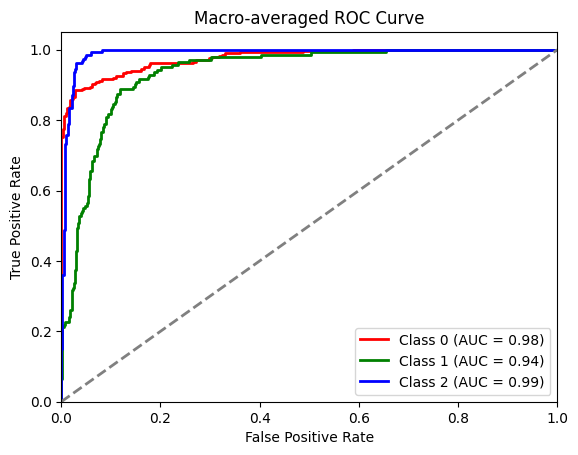

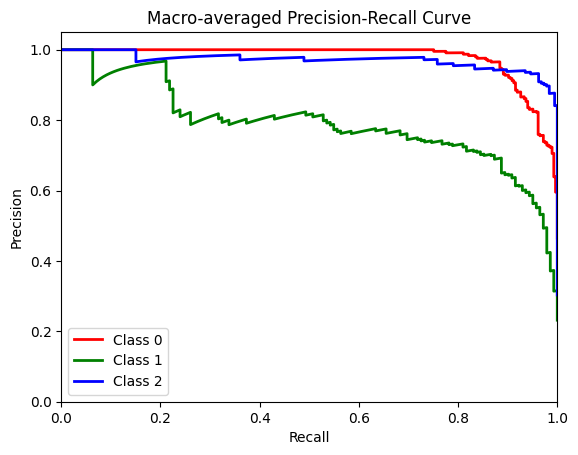

Overall Confusion Matrix:
[[268  16   1]
 [ 44  88  10]
 [  4  10 172]]
[features_array] (2451, 64)
[labels_array] (2451,)
[features_array] (613, 64)
[labels_array] (613,)


In [34]:
kfold_training_loop(train_images_path, train_labels, test_images_path, test_labels, num_folds=5, epochs_per_fold=5, batch_size=512)

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Load the extracted features and labels from the CSV files
train_data = pd.read_csv("train_features.csv")
test_data = pd.read_csv("test_features.csv")

# Separate features and labels
train_features = train_data.drop("label", axis=1).values
train_labels = train_data["label"].values
test_features = test_data.drop("label", axis=1).values
test_labels = test_data["label"].values

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = svm_classifier.predict(test_features)

# Evaluate the SVM classifier
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
confusion_metrics = confusion_matrix(test_labels, test_predictions)

print("[SVM] Overall Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Metrics:{confusion_metrics}")


[SVM] Overall Evaluation Metrics:
Accuracy: 0.8923327895595432
Precision: [0.94776119 0.78723404 0.89215686]
Recall: [0.89122807 0.78169014 0.97849462]
F1 Score: [0.91862568 0.7844523  0.93333333]
Confusion Metrics:[[254  27   4]
 [ 13 111  18]
 [  1   3 182]]


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

# Load the extracted features and labels from the CSV files
train_data = pd.read_csv("train_features.csv")
test_data = pd.read_csv("test_features.csv")

# Separate features and labels
train_features = train_data.drop("label", axis=1).values
train_labels = train_data["label"].values
test_features = test_data.drop("label", axis=1).values
test_labels = test_data["label"].values

# Initialize and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=27)  # You can adjust the number of neighbors as needed
knn_classifier.fit(train_features, train_labels)

# Make predictions on the test set
test_predictions = knn_classifier.predict(test_features)

# Evaluate the KNN classifier
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average=None, zero_division=0)
recall = recall_score(test_labels, test_predictions, average=None)
f1 = f1_score(test_labels, test_predictions, average=None)
confusion_metrics = confusion_matrix(test_labels, test_predictions)

print("[KNN] Overall Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Metrics: {confusion_metrics}")


[KNN] Overall Evaluation Metrics:
Accuracy: 0.9021207177814029
Precision: [0.94795539 0.8041958  0.91044776]
Recall: [0.89473684 0.80985915 0.98387097]
F1 Score: [0.92057762 0.80701754 0.94573643]
Confusion Metrics: [[255  27   3]
 [ 12 115  15]
 [  2   1 183]]


In [40]:
# @title Default title text
models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 